### Light python event model used to simulate Juster events
- liquidity providing risk estimation
- different market maker behaviur testing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

from dynamics import calc_dynamics_by_freq
from coinbase_api import CoinbaseAPI
from plot import plot_dynamics_hists
from user import User
from run_events import run_random_event
from params_generation import generate_params, clipped_normal

sns.set_style("whitegrid")

In [2]:
import sys
sys.path.insert(0, '../../tests')
from event_model import EventModel

### Getting data to use as source of the price dynamics:

In [3]:
api = CoinbaseAPI()

pair = 'XTZ-USD'
event_durations = [3600, 21600, 86400]

dfs = {
    duration: api.get_history_prices(pair=pair, granularity=duration)
    for duration in event_durations
}

dynamics = {
    duration: calc_dynamics_by_freq(dfs[duration], f'{duration}S')
    for duration in event_durations
}

### Current data distribution:

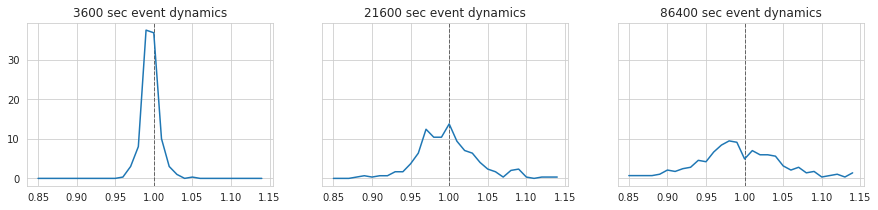

In [4]:
axes = plot_dynamics_hists(dynamics)

### Assumptions:

#### 1. Liquidity providers:
- there are two providers: one that adds liquidity in the event creation and second in random time during event (time selected using uniform distribution)
- first provider have expected market ratio that calculated as 

#### 2. Market expectation model:
- market ratio expectations are composed of different users expected ratio value
- users expected ratio value calculated before event creation and kept constant during event
- mean users expected ratio is equal to the real market ratio

#### 3. Users actions:
- user bets values are distributed exponentially
- bet pool is decided by difference between event pool and user expected pool
- MAYBE: user makes K bets proposals and selects one that leads event to the have the most close ratio to the user expectations (TODO: check this one, but I feel that it would change bet distribution)

## WIP
### TODO: process collected data: agregate, calculate stats
### TODO: collect metadata during event about bets and other params
### TODO: include DAO profit fee somewhere
### TODO: save data (?)
### TODO: analyze data to answer questions
- maybe using dash or another BI? find a way to make it interactive, so it would be easy to calculate mean event results

### ? TODO:
- make separate table with users ratio expecatations?

### To calculate expected market outcome for provider / users "clipped normal distribution" used, it looks like this:

<AxesSubplot:>

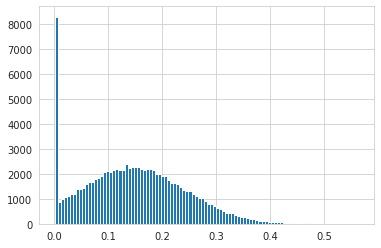

In [5]:
market_dynamics = dynamics[3600]
target_dynamics = 1.01

market_ratio = (market_dynamics >= target_dynamics).mean()
pd.Series(clipped_normal(market_ratio, 0.1, 100000)).hist(bins=100)

### TODO: there can be problems with event with analysing rates that too different from market ratio
- either need to change clipped_normal model
- either need to be very careful with events where target is not 0.5 and providers with big error rate
- but maybe it is OK, because if provider have big error: he suffers

### Running generation:

In [6]:
market_dynamics = dynamics[3600]
target_dynamics = 1.00
iterations = 1000
results = []


for _ in tqdm(range(iterations)):
    params = generate_params(market_dynamics, target_dynamics)
    results.append({
        **params,
        **run_random_event(**params).to_dict()
    })

df = pd.json_normalize(results)

100%|██████████| 1000/1000 [00:02<00:00, 349.25it/s]


<AxesSubplot:>

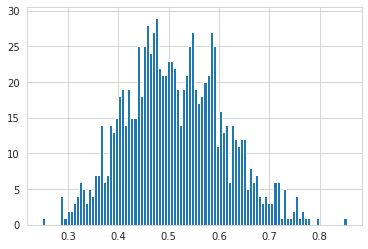

In [7]:
df.primary_provider_expected_a.hist(bins=100)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ticks,1000.0,1.000000e+03,0.000000e+00,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
bet_chance,1000.0,1.588690e-01,2.065135e-01,1.000000e-03,1.000000e-02,1.000000e-01,5.000000e-01,5.000000e-01
users_count,1000.0,5.081300e+01,2.833960e+01,2.000000e+00,2.600000e+01,5.000000e+01,7.600000e+01,9.900000e+01
actual_dynamics,1000.0,1.000233e+00,1.112732e-02,9.693998e-01,9.936546e-01,9.998889e-01,1.005686e+00,1.050086e+00
target_dynamics,1000.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...
diffs.user_93,26.0,-2.244735e+06,1.881827e+07,-4.072677e+07,-1.515989e+07,2.908138e+06,7.959024e+06,3.911386e+07
diffs.user_92,35.0,5.087951e+05,2.471785e+07,-4.515774e+07,-1.990110e+07,-1.128592e+06,1.967749e+07,4.275126e+07
diffs.user_88,55.0,-7.581489e+04,2.430334e+07,-5.611410e+07,-1.694529e+07,-2.522457e+06,1.475379e+07,4.904699e+07
diffs.user_91,43.0,-1.226190e+06,2.749729e+07,-5.756692e+07,-2.049476e+07,-1.660455e+06,1.613119e+07,9.369387e+07


### Questions:
- how liquidity provider error affects his returns?
- does users market expectance variance affect provider returns?
- how liquidity provider profit depends from bets frequency / size?
- what difference between risks and profits of the primary and the folowing providers?
- what are expected profits for providers for providers with different fees amount?
    - mean, median, q1 and q99 profits
- what mean APY is generated by events and is it possible to make APY predictions using expected market activity params?